# Data Preprocessing Tools

### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score


### Importing the dataset

In [2]:
df = pd.read_csv("Bank_Customer_Attrition_Insights_Data.csv") 

## Data Preprocessing & Cleaning

#### Check for missing values

In [3]:
df.info()
# Check for missing values in each column
#checking for NAN
for col in df.columns:
    print(col,df[col].isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Card 

#### Drop Unnecessary Columns

In [4]:
df.drop(["RowNumber", "CustomerId", "Surname"], axis=1, inplace=True)


### Encode Categorical Variables

#### Convert Categorical Data to Numerical

In [6]:
df["Geography"] = df["Geography"].replace(['France', 'Spain', 'Germany'], [0,1,2]).astype(int)
df["Gender"] = df["Gender"].replace(['Female', 'Male'], [0,1]).astype(int)
df["Card Type"] = df["Card Type"].replace(['SILVER', 'GOLD', 'DIAMOND', 'PLATINUM'], [0,1,2,3]).astype(int)




### Feature Scaling

In [7]:
sc = StandardScaler()
numeric_cols = ["CreditScore", "Age", "Balance", "EstimatedSalary", "Point Earned"]
df[numeric_cols] = sc.fit_transform(df[numeric_cols])

pd.set_option('future.no_silent_downcasting', True)



## Exploratory Data Analysis (EDA)

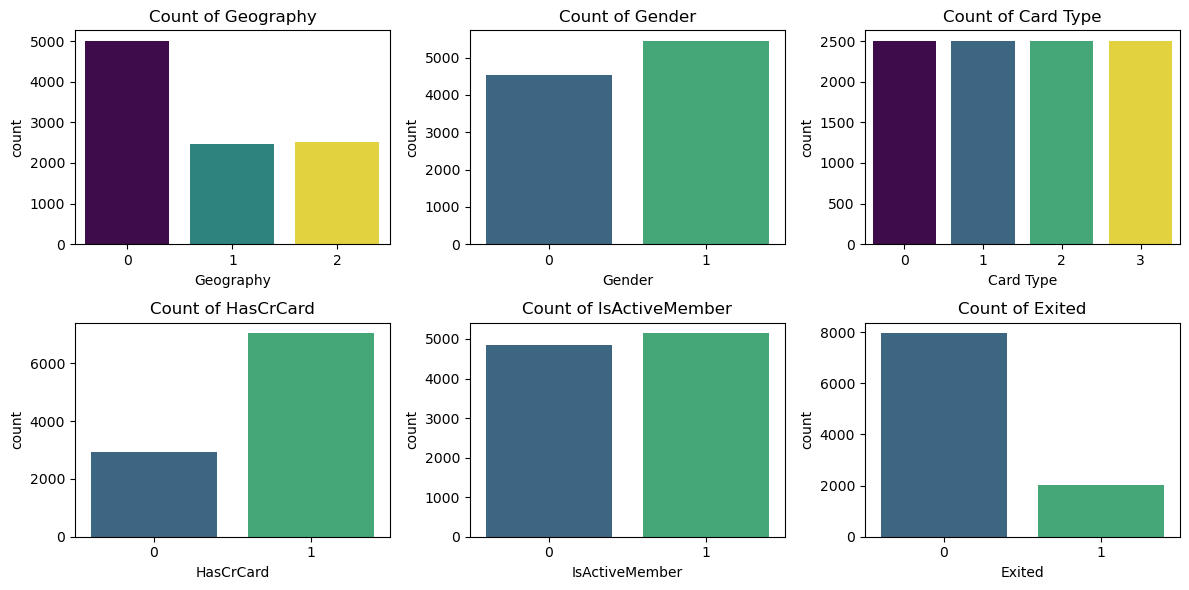

In [8]:
# Countplot for categorical variables
categorical_features = ['Geography', 'Gender', 'Card Type', 'HasCrCard', 'IsActiveMember', 'Exited']

plt.figure(figsize=(12, 6))
for i, col in enumerate(categorical_features, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=df[col], hue=df[col], palette="viridis", legend=False)

    plt.title(f"Count of {col}")
plt.tight_layout()
plt.show()


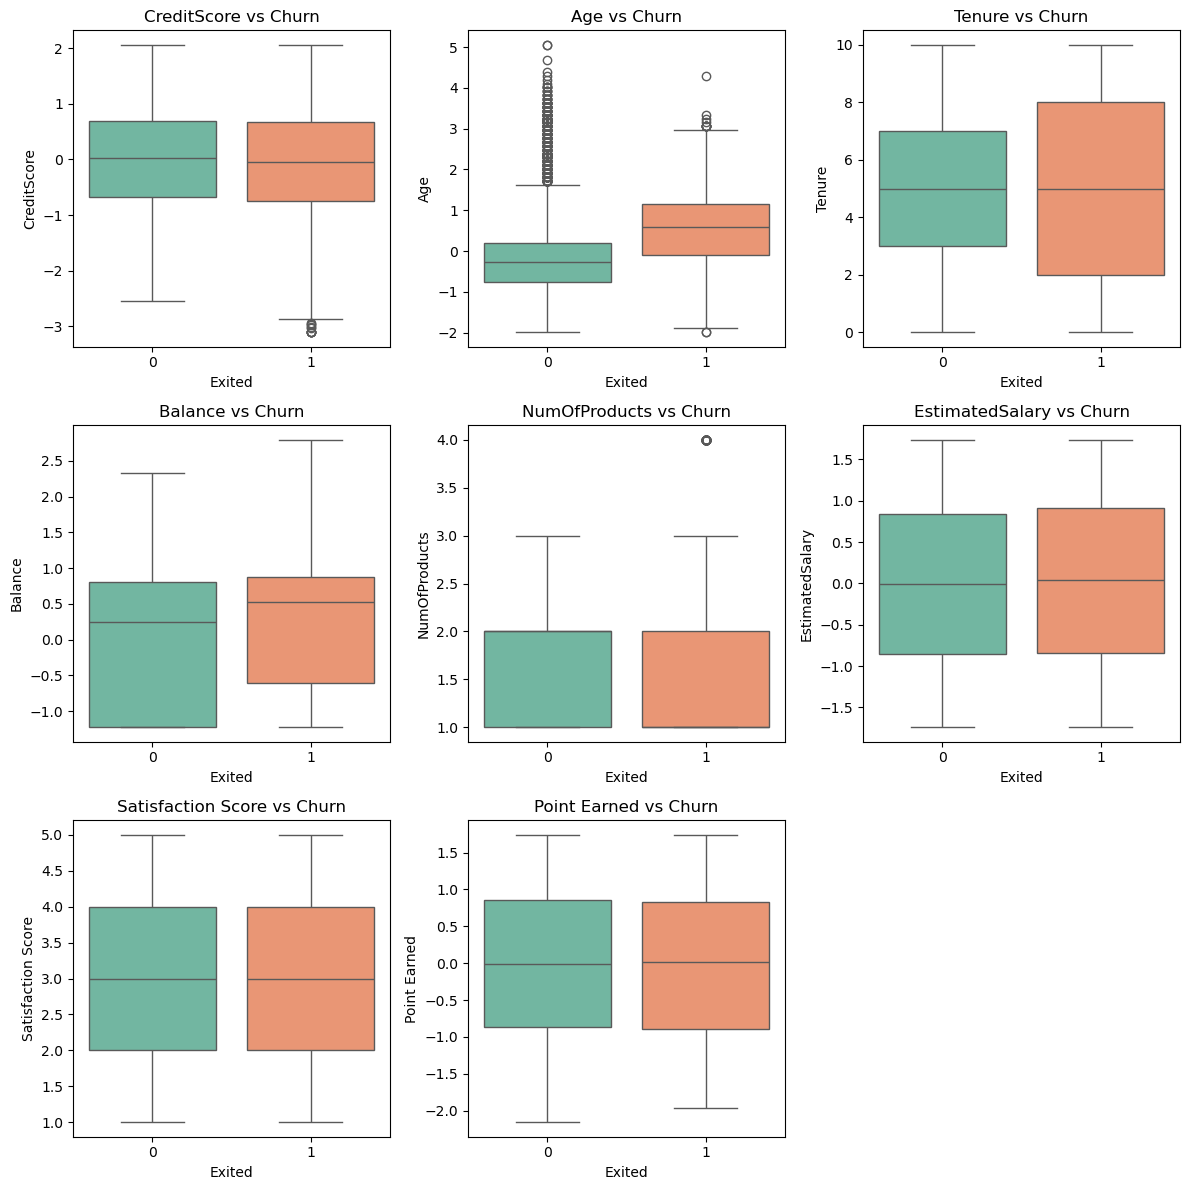

In [9]:
# Boxplot for numerical features vs. churn
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Satisfaction Score', 'Point Earned']

plt.figure(figsize=(12, 12))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df['Exited'], y=df[col], hue=df['Exited'], palette="Set2", legend=False)

    plt.title(f"{col} vs Churn")
plt.tight_layout()
plt.show()


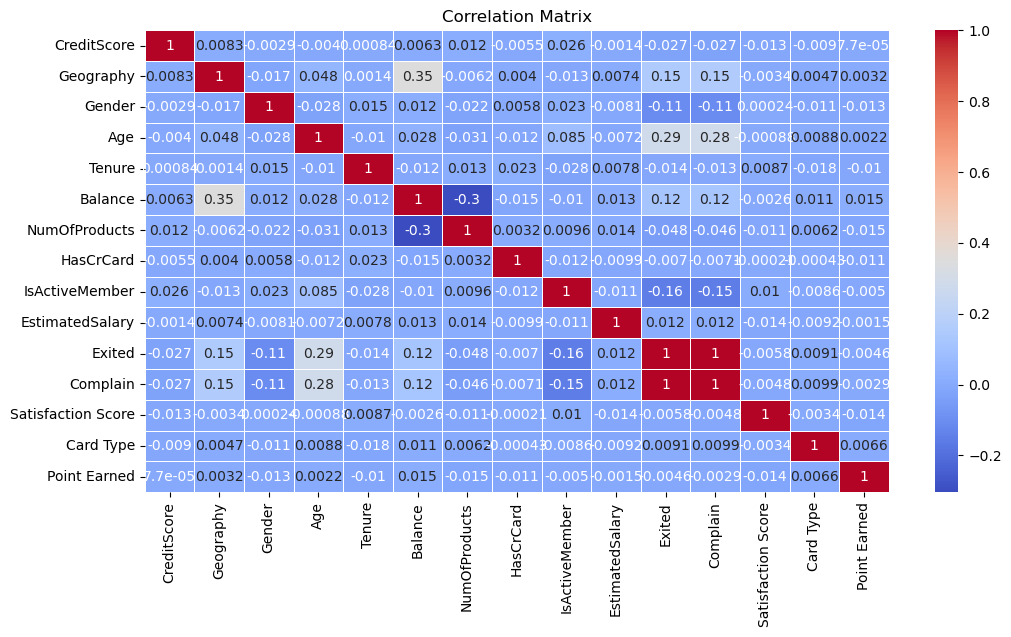

In [10]:
# Compute correlation matrix
corr_matrix = df.corr()

# Heatmap of correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


Churn Rate:
 Exited
0    79.62
1    20.38
Name: proportion, dtype: float64


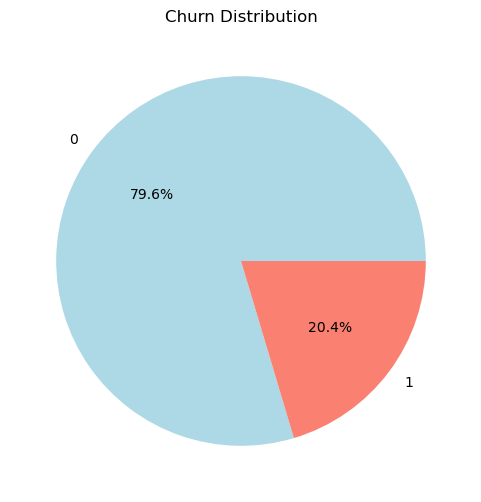

In [11]:
# Churn percentage
churn_rate = df['Exited'].value_counts(normalize=True) * 100
print("Churn Rate:\n", churn_rate)

# Pie chart for churn distribution
plt.figure(figsize=(6, 6))
df['Exited'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightblue', 'salmon'])
plt.title("Churn Distribution")
plt.ylabel('')
plt.show()


### Train Best Model & Evaluate

In [12]:
X = df.drop("Exited", axis=1)  # Features
y = df["Exited"]  # Target variable

# Splitting dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


### Handle Class Imbalance using SMOTE

In [13]:
smote = SMOTE(sampling_strategy="auto", random_state=42)  # Increase from 0.5
X_train, y_train = smote.fit_resample(X_train, y_train)



### Cross-Validation & Model Training

In [14]:
from sklearn.linear_model import LogisticRegression
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Logistic Regression
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg_scores = cross_val_score(log_reg, X_train, y_train, cv=cv, scoring='accuracy')
print(f"Logistic Regression Accuracy Scores: {log_reg_scores}")
print(f"Mean Accuracy: {log_reg_scores.mean():.4f}\n")


Logistic Regression Accuracy Scores: [0.99764521 0.99882261 0.99882261 0.99803768 0.99843014]
Mean Accuracy: 0.9984



In [15]:
from sklearn.tree import DecisionTreeClassifier
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_scores = cross_val_score(dt_model, X_train, y_train, cv=cv, scoring='accuracy')
print(f"Decision Tree Accuracy Scores: {dt_scores}")
print(f"Mean Accuracy: {dt_scores.mean():.4f}\n")

Decision Tree Accuracy Scores: [0.99882261 0.99686028 0.99882261 0.99803768 0.99725275]
Mean Accuracy: 0.9980



In [16]:
from xgboost import XGBClassifier
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# XGBoost
xgb_model = XGBClassifier(objective="binary:logistic", eval_metric="logloss", random_state=42)
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring='accuracy')
print(f"XGBoost Accuracy Scores: {xgb_scores}")
print(f"Mean Accuracy: {xgb_scores.mean():.4f}\n")


XGBoost Accuracy Scores: [0.99764521 0.99843014 0.99882261 0.99882261 0.99921507]
Mean Accuracy: 0.9986



In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='accuracy')

print(f"Cross-validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")


Cross-validation Accuracy Scores: [0.99764521 0.99882261 0.99882261 0.99882261 0.99882261]
Mean Accuracy: 0.9986


### Hyperparameter Tuning with GridSearchCV

In [18]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


### Train Best Model & Evaluate

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



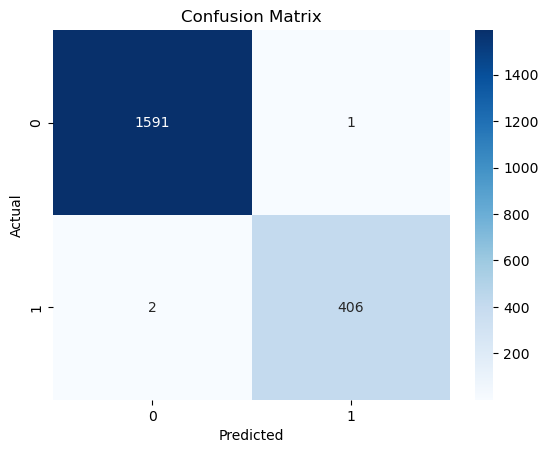

ROC-AUC Score: 0.9992


In [19]:
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])
print(f"ROC-AUC Score: {roc_auc:.4f}")


### Train XGBoost Model with Hyperparameter Tuning

In [20]:
model = XGBClassifier(objective="binary:logistic", eval_metric="logloss")


xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

xgb_grid_search = GridSearchCV(model, xgb_param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

print("Best Parameters for XGBoost:", xgb_grid_search.best_params_)


Best Parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}


 ### Train & Evaluate Best XGBoost Model

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1592
           1       1.00      1.00      1.00       408

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



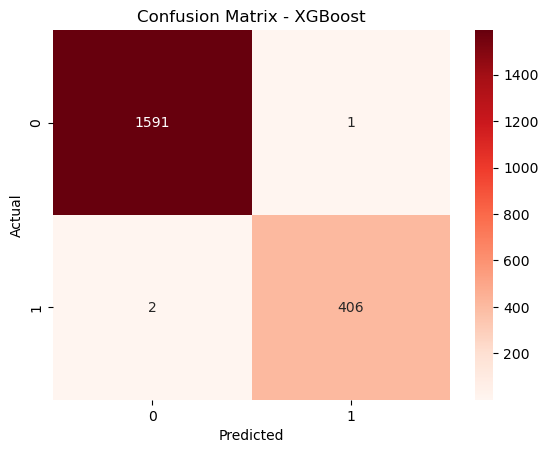

ROC-AUC Score (XGBoost): 0.9993


In [21]:
best_xgb = xgb_grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Reds')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

# ROC-AUC Score
roc_auc_xgb = roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:, 1])
print(f"ROC-AUC Score (XGBoost): {roc_auc_xgb:.4f}")


## Deployment & Interpretation

#### Feature Importance Analysis:

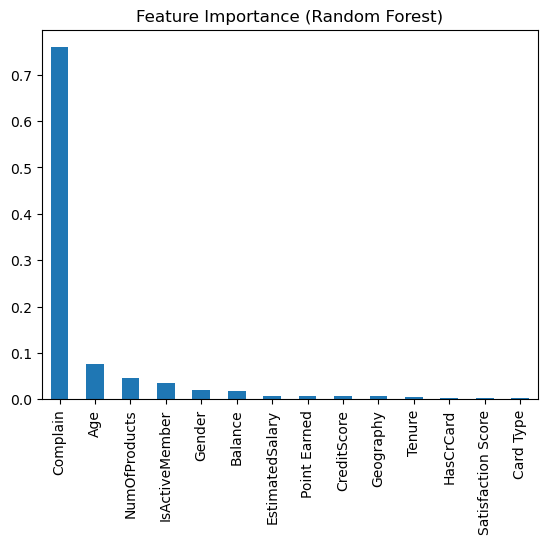

In [22]:
feature_importance = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importance.plot(kind='bar', title="Feature Importance (Random Forest)")
plt.show()


In [23]:
#Deploy Model: Save the trained model for later use:
import joblib
best_xgb = xgb_grid_search.best_estimator_
joblib.dump(best_xgb, "churn_prediction_model.pkl")

['churn_prediction_model.pkl']